# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points
        
    def get_points(self):
        return self.points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        
%matplotlib notebook

<hr style="border:2px solid gray">

# Rozwiązanie

## > Wprowadzanie danych

#### Generator odcinków

In [3]:
def orient(A, B, C, epsilon=10**-10): 
    det = A[0]*B[1] + A[1]*C[0] + B[0]*C[1] - B[1]*C[0] - A[1]*B[0] - A[0]*C[1]
    if det > epsilon: 
        return 1
    else: 
        return 2

In [4]:
def intersect(line1, line2):
    p1 = line1[0]
    q1 = line1[1]
    p2 = line2[0]
    q2 = line2[1]
    return orient(p1, q1, p2) != orient(p1, q1, q2) and orient(p2, q2, p1) != orient(p2, q2, q1)

In [5]:
def generateLines(quantity=5, minX=0, minY=0, maxX=100, maxY=100):
    result = []

    i = 0
    while i <= quantity:
        i += 1
        p = (random.uniform(minX,maxX), random.uniform(minY,maxY))
        q = (random.uniform(minX,maxX), random.uniform(minY,maxY))
        
        if p[0] == q[0]: 
            i -= 1
            continue
        isInsteresct = False
        for line in result:
            if (intersect(line, (p,q))):
                isInsteresct = True
        if isInsteresct: 
            i -= 1
            continue

        toAdd = True
        for res in result:
            if res[0][0] == p[0] or res[1][0] == p[0] or res[0][0] == q[0] or res[1][0] == q[0]: 
                toAdd = False
                break
        if toAdd:
            if p[0] < q[0]: result.append([p,q])
            else: result.append([q,p])
        else:
            i -= 1

    return result

#### Generacja odcinków, zapis do pliku

In [6]:
lines = generateLines()
with open('dane.json', 'w') as file:
   file.write(js.dumps(lines))

#### Odczyt odcinków z płótna, zapis do pliku

<IPython.core.display.Javascript object>


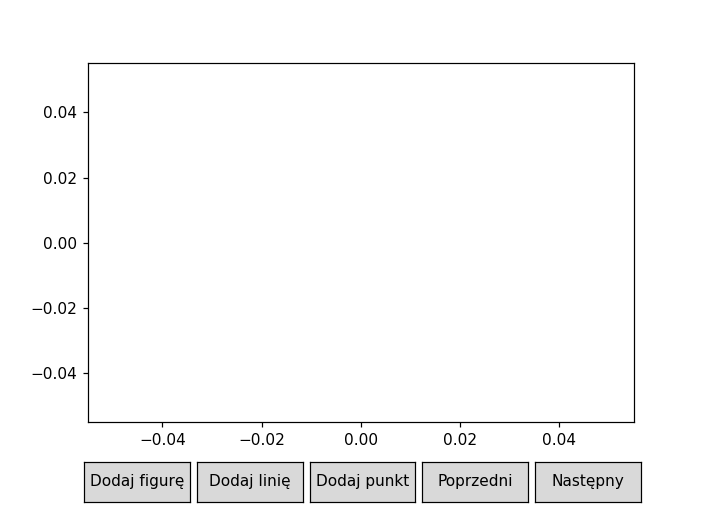

In [7]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [8]:
lines = []
for i in range(len(plot.get_added_lines())):
    for line in plot.get_added_lines()[i].lines:
        if line[0][0] < line[1][0]:
            lines.append(line)
        else:
            lines.append([line[1], line[0]])
        
with open('f1.json', 'w') as file:
   file.write(js.dumps(lines))

## > Struktury danych

#### Klasy obiektów

In [9]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

In [10]:
class Segment:
    def __init__(self, p, q):
        self.leftPoint = p
        self.rightPoint = q
        if q.x < p.x:
            self.leftPoint = q
            self.rightPoint = p

        self.m = (self.leftPoint.y - self.rightPoint.y) / (self.leftPoint.x - self.rightPoint.x)
        self.b = self.leftPoint.y - (self.m * self.leftPoint.x)

    def isPointAbove(self, point):
        if point.y > self.getY(point.x):
            return True
        return False

    def getY(self, x):
        if self.leftPoint.x <= x <= self.rightPoint.x:
            return (self.m * x) + self.b
        return None

In [11]:
class Trapezoid:
    def __init__(self, topSegment, bottomSegment, leftPoint, rightPoint):
        self.topSegment = topSegment
        self.bottomSegment = bottomSegment
        self.leftPoint = leftPoint
        self.rightPoint = rightPoint
        
        self.topLeft = None
        self.bottomLeft = None
        self.topRight = None
        self.bottomRight = None
        
        self.node = None

#### Graf poszukiwań (struktura D)

In [12]:
class SearchGraph:
    def __init__(self, root):
        self.root = root

    def updateRoot(self, root):
        self.root = root
        
    def query(self, point, node=None):
        if node is None:
            node = self.root
        if node.type == "tnode":
            return node.trapezoid
        if node.type == "xnode":
            if(point.x < node.point.x):
                return self.query(point, node.left)
            else:
                return self.query(point, node.right)
        if node.type == "ynode":
            if(point.y > node.segment.getY(point.x)):
                return self.query(point, node.above)
            else:
                return self.query(point, node.below)

In [13]:
class XNode:
    def __init__(self, point, left=None, right=None):
        self.type = 'xnode'
        self.setLeft(left)
        self.setRight(right)
        self.point = point

    def setLeft(self, node):
        self.left = node
        if node is None:
            return
        if node.type == 'tnode' and self not in node.parents:
            node.parents.append(self)

    def setRight(self, node):
        self.right = node
        if node is None:
            return
        if node.type == 'tnode' and self not in node.parents:
            node.parents.append(self)

In [14]:
class YNode:
    def __init__(self, segment, above=None, below=None):
        self.type = 'ynode'
        self.setAbove(above)
        self.setBelow(below)
        self.segment = segment

    def setAbove(self, node):
        self.above = node
        if node is None:
            return
        if node.type == 'tnode' and self not in node.parents:
            node.parents.append(self)

    def setBelow(self, node):
        self.below = node
        if node is None:
            return
        if node.type == 'tnode' and self not in node.parents:
            node.parents.append(self)

In [15]:
class TNode:
    def __init__(self, trapezoid):
        self.type = 'tnode'
        self.parents = []
        self.trapezoid = trapezoid
        self.trapezoid.node = self

    def replaceNode(self, searchGraph, node):
        if self.parents == []:
            searchGraph.updateRoot(node)
            return
        for parent in self.parents:
            if parent.type == 'xnode':
                if parent.left == self:
                    parent.setLeft(node)
                else:
                    parent.setRight(node)
            else:
                if parent.above == self:
                    parent.setAbove(node)
                else:
                    parent.setBelow(node)

## > Budowa mapy

#### Funkcje pomocnicze

In [16]:
def permutate(S):
    return random.sample(S, len(S))

In [17]:
def updateLeftNeighbors(oldTrapezoid, newTrapezoid):
    if oldTrapezoid.topLeft:
        if oldTrapezoid.topLeft.topRight == oldTrapezoid:
            oldTrapezoid.topLeft.topRight = newTrapezoid
        if oldTrapezoid.topLeft.bottomRight == oldTrapezoid:
            oldTrapezoid.topLeft.bottomRight = newTrapezoid
    if oldTrapezoid.bottomLeft:
        if oldTrapezoid.bottomLeft.topRight == oldTrapezoid:
            oldTrapezoid.bottomLeft.topRight = newTrapezoid
        if oldTrapezoid.bottomLeft.bottomRight == oldTrapezoid:
            oldTrapezoid.bottomLeft.bottomRight = newTrapezoid

In [18]:
def updateRightNeighbors(oldTrapezoid, newTrapezoid):
    if oldTrapezoid.topRight:
        if oldTrapezoid.topRight.topLeft == oldTrapezoid:
            oldTrapezoid.topRight.topLeft = newTrapezoid
        if oldTrapezoid.topRight.bottomLeft == oldTrapezoid:
            oldTrapezoid.topRight.bottomLeft = newTrapezoid
    if oldTrapezoid.bottomRight:
        if oldTrapezoid.bottomRight.topLeft == oldTrapezoid:
            oldTrapezoid.bottomRight.topLeft = newTrapezoid
        if oldTrapezoid.bottomRight.bottomLeft == oldTrapezoid:
            oldTrapezoid.bottomRight.bottomLeft = newTrapezoid

In [19]:
def findIntersectingTrapezoids(startTrapezoid, endTrapezoid, segment, intersectingTrapezoids):
    current = startTrapezoid
    intersectingTrapezoids.clear()
    intersectingTrapezoids.append(current)
    while segment.rightPoint.x > current.rightPoint.x:
        if current.rightPoint.y <= segment.getY(current.rightPoint.x):
            current = current.topRight
        else:
            current = current.bottomRight
        intersectingTrapezoids.append(current) 

#### Funkcja uruchomieniowa

In [20]:
def main(lines):

    scenes = []
    addedTrapezoidsLines = []
    allLinesAdded = []
    lineSegments = []

    for i in permutate(lines):  
        point1 = Point(i[0][0], i[0][1])
        point2 = Point(i[1][0], i[1][1])
        lineSegments.append(Segment(point1, point2))

    rootTrapezoid = createOuterTrapezoid(lines)
    rootNode = TNode(rootTrapezoid)
    searchGraph = SearchGraph(rootNode)

    for segment in lineSegments:
        
        sphereForSegment = []
        startTrapezoid = searchGraph.query(segment.leftPoint)
        endTrapezoid = searchGraph.query(segment.rightPoint)
        findIntersectingTrapezoids(startTrapezoid, endTrapezoid, segment, sphereForSegment)

        if startTrapezoid == endTrapezoid:
            addedTrapezoids = insertSegmentInOneTrapezoid(searchGraph, sphereForSegment[0], segment)     
        else:
            addedTrapezoids = insertSegmentInManyTrapezoids(searchGraph, sphereForSegment, segment)

        addedTrapezoidsLines = visualise(segment, addedTrapezoidsLines, allLinesAdded, sphereForSegment, addedTrapezoids, scenes)

    return searchGraph, scenes

#### Dodawanie segmentów do mapy

In [21]:
def insertSegmentInOneTrapezoid(searchGraph, trapezoid, segment):
    
    leftTrapezoid = Trapezoid(trapezoid.topSegment, trapezoid.bottomSegment, trapezoid.leftPoint, segment.leftPoint)
    topTrapezoid = Trapezoid(trapezoid.topSegment, segment, segment.leftPoint, segment.rightPoint)
    bottomTrapezoid = Trapezoid(segment, trapezoid.bottomSegment, segment.leftPoint, segment.rightPoint)
    rightTrapezoid = Trapezoid(trapezoid.topSegment, trapezoid.bottomSegment, segment.rightPoint, trapezoid.rightPoint)

    leftTrapezoid.topRight = topTrapezoid
    leftTrapezoid.topLeft = trapezoid.topLeft
    leftTrapezoid.bottomRight = bottomTrapezoid
    leftTrapezoid.bottomLeft = trapezoid.bottomLeft
    
    topTrapezoid.topRight = rightTrapezoid
    topTrapezoid.topLeft = leftTrapezoid
    topTrapezoid.bottomRight = rightTrapezoid
    topTrapezoid.bottomLeft = leftTrapezoid
    
    bottomTrapezoid.topRight = rightTrapezoid
    bottomTrapezoid.topLeft = leftTrapezoid
    bottomTrapezoid.bottomRight = rightTrapezoid
    bottomTrapezoid.bottomLeft = leftTrapezoid
    
    rightTrapezoid.topRight = trapezoid.topRight
    rightTrapezoid.topLeft = topTrapezoid
    rightTrapezoid.bottomRight = trapezoid.bottomRight
    rightTrapezoid.bottomLeft = bottomTrapezoid
    
    updateLeftNeighbors(trapezoid, leftTrapezoid)
    updateRightNeighbors(trapezoid, rightTrapezoid)
    
    leftTrapezoidNode = TNode(leftTrapezoid)
    topTrapezoidNode = TNode(topTrapezoid)
    bottomTrapezoidNode = TNode(bottomTrapezoid)
    rightTrapezoidNode = TNode(rightTrapezoid)
    
    sNode = YNode(segment, topTrapezoidNode, bottomTrapezoidNode)
    qNode = XNode(segment.rightPoint, sNode, rightTrapezoidNode)
    pNode = XNode(segment.leftPoint, leftTrapezoidNode, qNode)
    trapezoid.node.replaceNode(searchGraph, pNode)

    return [leftTrapezoid, topTrapezoid, bottomTrapezoid, rightTrapezoid]

In [22]:
def insertSegmentInManyTrapezoids(searchGraph, intersectingTrapezoids, segment):

    upperMidTrapezoid = None
    lowerMidTrapezoid = None
    mergeUpper = False

    addedTrapezoids = []
    
    for trapezoid in intersectingTrapezoids:

        if trapezoid == intersectingTrapezoids[0]:

            leftTrapezoid = Trapezoid(trapezoid.topSegment, trapezoid.bottomSegment, trapezoid.leftPoint, segment.leftPoint)
            if segment.isPointAbove(trapezoid.rightPoint):
                upperMidTrapezoid = Trapezoid(trapezoid.topSegment, segment, segment.leftPoint, trapezoid.rightPoint)
                lowerMidTrapezoid = Trapezoid(segment, trapezoid.bottomSegment, segment.leftPoint, None)
                mergeUpper = False
            else:
                upperMidTrapezoid = Trapezoid(trapezoid.topSegment, segment, segment.leftPoint, None)
                lowerMidTrapezoid = Trapezoid(segment, trapezoid.bottomSegment, segment.leftPoint, trapezoid.rightPoint)
                mergeUpper = True
                
            leftTrapezoid.topRight = upperMidTrapezoid
            leftTrapezoid.topLeft = trapezoid.topLeft
            leftTrapezoid.bottomRight = lowerMidTrapezoid
            leftTrapezoid.bottomLeft = trapezoid.bottomLeft
            
            if mergeUpper:
                upperMidTrapezoid.topRight = trapezoid.topRight
                upperMidTrapezoid.bottomRight = trapezoid.topRight
                lowerMidTrapezoid.topRight = trapezoid.topRight
                lowerMidTrapezoid.bottomRight = trapezoid.bottomRight
            else:
                upperMidTrapezoid.topRight = trapezoid.topRight
                upperMidTrapezoid.bottomRight = trapezoid.bottomRight
                lowerMidTrapezoid.topRight = trapezoid.bottomRight
                lowerMidTrapezoid.bottomRight = trapezoid.bottomRight
            
            upperMidTrapezoid.topLeft = leftTrapezoid
            upperMidTrapezoid.bottomLeft = leftTrapezoid
            
            lowerMidTrapezoid.topLeft = leftTrapezoid
            lowerMidTrapezoid.bottomLeft = leftTrapezoid
            
            updateLeftNeighbors(trapezoid, leftTrapezoid)

            if mergeUpper:
                updateRightNeighbors(trapezoid, lowerMidTrapezoid)
            else:
                updateRightNeighbors(trapezoid, upperMidTrapezoid)

            addedTrapezoids.append(leftTrapezoid)
            addedTrapezoids.append(upperMidTrapezoid)
            addedTrapezoids.append(lowerMidTrapezoid)

            leftTrapezoidNode = TNode(leftTrapezoid)
            upperMidTrapezoidNode = TNode(upperMidTrapezoid)
            lowerMidTrapezoidNode = TNode(lowerMidTrapezoid)
                
            sNode = YNode(segment, upperMidTrapezoidNode, lowerMidTrapezoidNode)
            pNode = XNode(segment.leftPoint, leftTrapezoidNode, sNode)
            trapezoid.node.replaceNode(searchGraph, pNode)

        elif trapezoid == intersectingTrapezoids[-1]:

            rightTrapezoid = Trapezoid(trapezoid.topSegment, trapezoid.bottomSegment, segment.rightPoint, trapezoid.rightPoint)
            if mergeUpper:
                upperMidTrapezoid.rightPoint = segment.rightPoint
                lowerMidTrapezoid = Trapezoid(segment, trapezoid.bottomSegment, trapezoid.leftPoint, segment.rightPoint)
                upperMidTrapezoidNode = upperMidTrapezoid.node
                lowerMidTrapezoidNode = TNode(lowerMidTrapezoid)
            else:
                upperMidTrapezoid = Trapezoid(trapezoid.topSegment, segment, trapezoid.leftPoint, segment.rightPoint)
                lowerMidTrapezoid.rightPoint = segment.rightPoint
                upperMidTrapezoidNode = TNode(upperMidTrapezoid)
                lowerMidTrapezoidNode = lowerMidTrapezoid.node
                
            rightTrapezoid.topRight = trapezoid.topRight
            rightTrapezoid.topLeft = upperMidTrapezoid
            rightTrapezoid.bottomRight = trapezoid.bottomRight
            rightTrapezoid.bottomLeft = lowerMidTrapezoid

            upperMidTrapezoid.topRight = rightTrapezoid
            upperMidTrapezoid.bottomRight = rightTrapezoid
            lowerMidTrapezoid.topRight = rightTrapezoid
            lowerMidTrapezoid.bottomRight = rightTrapezoid
            
            if mergeUpper:
                lowerMidTrapezoid.topLeft = trapezoid.topLeft
                lowerMidTrapezoid.bottomLeft = trapezoid.bottomLeft
            else:
                upperMidTrapezoid.topLeft = trapezoid.topLeft
                upperMidTrapezoid.bottomLeft = trapezoid.bottomLeft
            
            updateRightNeighbors(trapezoid, rightTrapezoid)

            if mergeUpper:
                updateLeftNeighbors(trapezoid, lowerMidTrapezoid)
            else:
                updateLeftNeighbors(trapezoid, upperMidTrapezoid) 
            
            addedTrapezoids.append(upperMidTrapezoid)
            addedTrapezoids.append(lowerMidTrapezoid)
            addedTrapezoids.append(rightTrapezoid)
                
            rightTrapezoidNode = TNode(rightTrapezoid)
            
            sNode = YNode(segment, upperMidTrapezoidNode, lowerMidTrapezoidNode)
            qNode = XNode(segment.rightPoint, sNode, rightTrapezoidNode)
            trapezoid.node.replaceNode(searchGraph, qNode)

        else:
            
            change = False

            if mergeUpper:
                oldLowerMidTrapezoid = lowerMidTrapezoid
                lowerMidTrapezoid = Trapezoid(segment, trapezoid.bottomSegment, trapezoid.leftPoint, None)
                upperMidTrapezoidNode = upperMidTrapezoid.node
                lowerMidTrapezoidNode = TNode(lowerMidTrapezoid)
            else:
                oldUpperMidTrapezoid = upperMidTrapezoid
                upperMidTrapezoid = Trapezoid(trapezoid.topSegment, segment, trapezoid.leftPoint, None)
                upperMidTrapezoidNode = TNode(upperMidTrapezoid)
                lowerMidTrapezoidNode = lowerMidTrapezoid.node

            if segment.isPointAbove(trapezoid.rightPoint):
                upperMidTrapezoid.rightPoint = trapezoid.rightPoint
                if mergeUpper == True:
                    change = True
                mergeUpper = False
                addedTrapezoids.append(upperMidTrapezoid)
            else:
                lowerMidTrapezoid.rightPoint = trapezoid.rightPoint
                if mergeUpper == False:
                    change = True
                mergeUpper = True
                addedTrapezoids.append(lowerMidTrapezoid)
                
            if mergeUpper:
                if change:
                    upperMidTrapezoid.topRight = trapezoid.topRight
                    upperMidTrapezoid.bottomRight = trapezoid.topRight
                    upperMidTrapezoid.topLeft = trapezoid.topLeft
                    upperMidTrapezoid.bottomLeft = oldUpperMidTrapezoid

                    lowerMidTrapezoid.topRight = trapezoid.topRight
                    lowerMidTrapezoid.bottomRight = trapezoid.bottomRight
                    
                    updateLeftNeighbors(trapezoid, upperMidTrapezoid)
                    updateRightNeighbors(trapezoid, lowerMidTrapezoid)
                else:
                    upperMidTrapezoid.topRight = trapezoid.topRight
                    upperMidTrapezoid.bottomRight = trapezoid.topRight

                    lowerMidTrapezoid.topRight = trapezoid.topRight
                    lowerMidTrapezoid.bottomRight = trapezoid.bottomRight
                    lowerMidTrapezoid.topLeft = oldLowerMidTrapezoid
                    lowerMidTrapezoid.bottomLeft = trapezoid.bottomLeft
                    
                    updateLeftNeighbors(trapezoid, lowerMidTrapezoid)
                    updateRightNeighbors(trapezoid, lowerMidTrapezoid)   
            else:
                if change:
                    upperMidTrapezoid.topRight = trapezoid.topRight
                    upperMidTrapezoid.bottomRight = trapezoid.bottomRight

                    lowerMidTrapezoid.topRight = trapezoid.bottomRight
                    lowerMidTrapezoid.bottomRight = trapezoid.bottomRight
                    lowerMidTrapezoid.topLeft = oldLowerMidTrapezoid
                    lowerMidTrapezoid.bottomLeft = trapezoid.bottomLeft
                    
                    updateLeftNeighbors(trapezoid, lowerMidTrapezoid)
                    updateRightNeighbors(trapezoid, upperMidTrapezoid)
                else:
                    upperMidTrapezoid.topRight = trapezoid.topRight
                    upperMidTrapezoid.topLeft = trapezoid.topLeft
                    upperMidTrapezoid.bottomRight = trapezoid.bottomRight
                    upperMidTrapezoid.bottomLeft = oldUpperMidTrapezoid

                    lowerMidTrapezoid.topRight = trapezoid.bottomRight
                    lowerMidTrapezoid.bottomRight = trapezoid.bottomRight
                    
                    updateLeftNeighbors(trapezoid, upperMidTrapezoid)
                    updateRightNeighbors(trapezoid, upperMidTrapezoid)

            sNode = YNode(segment, upperMidTrapezoidNode, lowerMidTrapezoidNode)
            trapezoid.node.replaceNode(searchGraph, sNode)
            
    uniqueTrapezoids = []
    for trapezoid in addedTrapezoids:
        if trapezoid not in uniqueTrapezoids:
            uniqueTrapezoids.append(trapezoid)      
    return uniqueTrapezoids

## > Wizualizacja

In [23]:
def visualise(segment, addedTrapezoidsLines, allLinesAdded, sphereForSegment, addedTrapezoids, scenes):
    
    sphereLines = []
    for sphereTrapezoid in sphereForSegment:
        sphereLines += trapezoidLines(sphereTrapezoid)
    
    scenes.append(Scene([PointsCollection([],color = 'blue')],
            [LinesCollection(addedTrapezoidsLines[:],color="lightskyblue"),
            LinesCollection(sphereLines[:],color="green"),
            LinesCollection(allLinesAdded[:],color="darkcyan"),
            LinesCollection([((segment.leftPoint.x,segment.leftPoint.y),(segment.rightPoint.x,segment.rightPoint.y))],color = "gold")]))
        
    sphereTrapezoidsLines = []
    for trapezoid in addedTrapezoids:
        addedTrapezoidsLines = cutVerticalLines(addedTrapezoidsLines,trapezoid)   
        scenes.append(Scene([PointsCollection([(trapezoid.leftPoint.x, trapezoid.leftPoint.y),(trapezoid.rightPoint.x,trapezoid.rightPoint.y)],color = 'black')],
                    [LinesCollection(addedTrapezoidsLines[:], color="lightskyblue"),
                    LinesCollection(sphereLines[:] ,color="mediumaquamarine"),
                    LinesCollection(sphereTrapezoidsLines[:], color="indigo"),
                    LinesCollection(trapezoidLines(trapezoid), color="red"),
                    LinesCollection(allLinesAdded[:], color="darkcyan"),
                    LinesCollection([((segment.leftPoint.x,segment.leftPoint.y),(segment.rightPoint.x,segment.rightPoint.y))],color = "gold")]))
        sphereTrapezoidsLines += trapezoidLines(trapezoid)
        sphereTrapezoidsLines += [((segment.leftPoint.x,segment.leftPoint.y),(segment.rightPoint.x,segment.rightPoint.y))]
        addedTrapezoidsLines += sphereTrapezoidsLines
        
    allLinesAdded.append(((segment.leftPoint.x,segment.leftPoint.y),((segment.rightPoint.x,segment.rightPoint.y))))
    scenes.append(Scene([PointsCollection([], color = 'blue')],
                        [LinesCollection(addedTrapezoidsLines[:], color="lightskyblue"),
                        LinesCollection(allLinesAdded[:], color="darkcyan")]))
    
    return addedTrapezoidsLines

#### Funkcje pomocnicze do wizualizacji

In [24]:
def minAndMaxFromLines(lines):

    x1 = min(lines, key = lambda x: x[0][0])[0][0]
    x2 = max(lines, key = lambda x: x[1][0])[1][0]
    y11 = min(lines, key = lambda x: x[0][1])[0][1]
    y12 = min(lines, key = lambda x: x[1][1])[1][1]
    y21 = max(lines, key = lambda x: x[0][1])[0][1]
    y22 = max(lines, key = lambda x: x[1][1])[1][1]

    y1 = 0
    y2 = 0
    if y11 > y12: y1 = y12
    else: y1 = y11
    if y21 < y22: y2 = y22
    else: y2 = y21

    borderX = (x2-x1)/100*10
    borderY = (y2-y1)/100*10

    return x1-borderX, x2+borderX, y1-borderY, y2+borderY

In [25]:
def trapezoidLines(trapezoid):
    resLines = []

    if trapezoid.leftPoint:
        if trapezoid.topSegment:
            tmpLeftSegmentValue = trapezoid.topSegment.getY(trapezoid.leftPoint.x)
            if tmpLeftSegmentValue and tmpLeftSegmentValue > trapezoid.leftPoint.y:
                point1 = (trapezoid.leftPoint.x,trapezoid.leftPoint.y)
                iP = (trapezoid.leftPoint.x,tmpLeftSegmentValue)
                resLines.append((point1,iP))
        if trapezoid.bottomSegment:
            tmpLeftSegmentValue = trapezoid.bottomSegment.getY(trapezoid.leftPoint.x)        
            if tmpLeftSegmentValue and tmpLeftSegmentValue < trapezoid.leftPoint.y:
                point1 = (trapezoid.leftPoint.x,trapezoid.leftPoint.y)
                iP = (trapezoid.leftPoint.x,tmpLeftSegmentValue)
                resLines.append((iP,point1))
    if trapezoid.rightPoint:
        if trapezoid.topSegment:
            tmpRightSegmentValue = trapezoid.topSegment.getY(trapezoid.rightPoint.x)
            if tmpRightSegmentValue and tmpRightSegmentValue > trapezoid.rightPoint.y:
                point1 = (trapezoid.rightPoint.x,trapezoid.rightPoint.y)
                iP = (trapezoid.rightPoint.x,tmpRightSegmentValue)
                resLines.append((point1,iP))
        if trapezoid.bottomSegment:
            tmpRightSegmentValue = trapezoid.bottomSegment.getY(trapezoid.rightPoint.x)
            if tmpRightSegmentValue and tmpRightSegmentValue < trapezoid.rightPoint.y:
                point1 = (trapezoid.rightPoint.x,trapezoid.rightPoint.y)
                iP = (trapezoid.rightPoint.x,tmpRightSegmentValue)
                resLines.append((iP,point1))    

    if trapezoid.leftPoint and trapezoid.rightPoint:
         if trapezoid.topSegment and trapezoid.bottomSegment:
                
            tmpLeftSegmentValue1 = trapezoid.topSegment.getY(trapezoid.leftPoint.x)
            tmpRightSegmentValue1 = trapezoid.topSegment.getY(trapezoid.rightPoint.x)
            tmpLeftSegmentValue2 = trapezoid.bottomSegment.getY(trapezoid.leftPoint.x)
            tmpRightSegmentValue2 = trapezoid.bottomSegment.getY(trapezoid.rightPoint.x)
    
            if not (tmpRightSegmentValue1 and tmpRightSegmentValue > trapezoid.rightPoint.y and tmpLeftSegmentValue and tmpLeftSegmentValue < trapezoid.leftPoint.y):
                if tmpLeftSegmentValue1 and tmpRightSegmentValue1:
                    resLines.append(((trapezoid.leftPoint.x,tmpLeftSegmentValue1),(trapezoid.rightPoint.x,tmpRightSegmentValue1)))
                if tmpLeftSegmentValue2 and tmpRightSegmentValue2:
                    resLines.append(((trapezoid.leftPoint.x,tmpLeftSegmentValue2),(trapezoid.rightPoint.x,tmpRightSegmentValue2)))
                    
    return resLines

In [26]:
def cutVerticalLines(lines, trapezoid):
    result = []
    for i in lines:
        
        if (not i[0][0] or not i[0][1] or not i[1][0] or not i[1][1]):
            result.append(i)
            continue
        if i[0][0] != i[1][0]:
            result.append(i)
            continue
        if i[0][1] > i[1][1]:
            lowerPoint = i[1]
            higherPoint = i[0]
        else:
            lowerPoint = i[0]
            higherPoint = i[1]

        if trapezoid.leftPoint.x < lowerPoint[0] and trapezoid.rightPoint.x > higherPoint[0]:
            if not trapezoid.bottomSegment.getY(higherPoint[0]) or not trapezoid.topSegment.getY(lowerPoint[0]):
                result.append(i)
            elif trapezoid.topSegment.getY(lowerPoint[0]) <= lowerPoint[1]:
                result.append(i)
            elif trapezoid.topSegment.getY(lowerPoint[0]) > lowerPoint[1] and trapezoid.bottomSegment.getY(higherPoint[0]) <= higherPoint[1]:
                if higherPoint[1] <= trapezoid.bottomSegment.getY(lowerPoint[0]):
                    i2 = ((lowerPoint[0],trapezoid.bottomSegment.getY(lowerPoint[0])),lowerPoint)
                    result.append(i2)
            elif trapezoid.bottomSegment.getY(higherPoint[0]) > higherPoint[1]:
                result.append(i)
            elif trapezoid.bottomSegment.getY(higherPoint[0]) <= higherPoint[1]:
                if lowerPoint[1] <= trapezoid.bottomSegment.getY(lowerPoint[0]):
                    i2 = (lowerPoint,(lowerPoint[0],trapezoid.bottomSegment.getY(lowerPoint[0])))
                    result.append(i2)
                end = None
            else:
                result.append(i)
        else:
            result.append(i)
               
    return result

In [27]:
def createOuterTrapezoid(lines):

    x1, x2, y1, y2 = minAndMaxFromLines(lines)
    lowerLeft = Point(x1, y1)
    upperRight = Point(x2, y2)
    lowerRight = Point(x2, y1)
    upperLeft = Point(x1, y2)
    topSegment = Segment(upperLeft, upperRight)
    bottomSegment = Segment(lowerLeft, lowerRight)

    return Trapezoid(topSegment, bottomSegment, upperLeft, upperRight)

#### Wyświetlanie szukanego punktu

In [28]:
def findPoint(searchGraph, point, background):
    
    trapezoid = searchGraph.query(point)
    
    topLeft = (trapezoid.leftPoint.x, trapezoid.topSegment.getY(trapezoid.leftPoint.x))
    bottomLeft = (trapezoid.leftPoint.x, trapezoid.bottomSegment.getY(trapezoid.leftPoint.x))
    topRight = (trapezoid.rightPoint.x, trapezoid.topSegment.getY(trapezoid.rightPoint.x))
    bottomRight = (trapezoid.rightPoint.x, trapezoid.bottomSegment.getY(trapezoid.rightPoint.x))
    
    print("Corners of the trapezoid:")
    print("Top left: ", topLeft)
    print("Bottom left: ", bottomLeft)
    print("Top right: ", topRight)
    print("Bottom right: ", bottomRight)
    
    mapLines = background.lines
    trapezoidLines = [[topLeft, bottomLeft], [bottomLeft, bottomRight], [bottomRight, topRight], [topRight, topLeft]]
    
    mapLines = mapLines.copy()
    mapLines.append(LinesCollection(trapezoidLines, color='red'))
    scene = Scene([PointsCollection([(point.x, point.y)], color='red')], mapLines)

    plot = Plot(scenes=[scene])
    plot.draw()

## > Wykonywanie programu

#### Odczyt linii z pliku

<IPython.core.display.Javascript object>


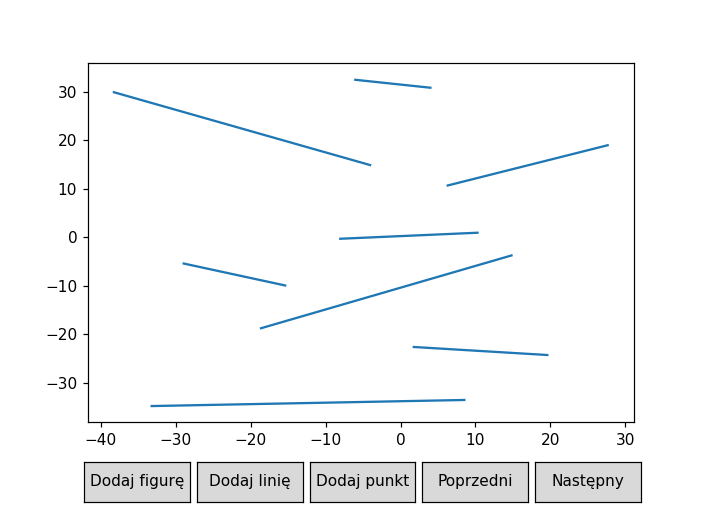

In [32]:
with open('hard2.json', 'r') as file:
    lines = js.loads(file.read())
plot = Plot(lines=[LinesCollection(lines)])
plot.draw()

#### Tworzenie mapy, wizualizacja

<IPython.core.display.Javascript object>


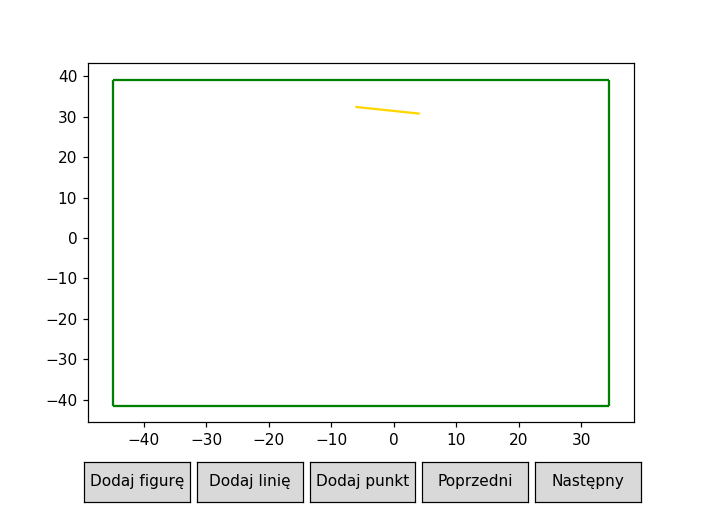

In [194]:
searchGraph, scenes = main(lines)
plot = Plot(scenes=scenes)
plot.draw()

#### Poszukiwanie punktu

Corners of the trapezoid:
Top left:  (1.6210076483770592, -9.710593810400011)
Bottom left:  (1.6210076483770592, -22.64812775790014)
Top right:  (14.951923904534695, -3.7220409788060635)
Bottom right:  (14.951923904534695, -23.886501337272964)


<IPython.core.display.Javascript object>


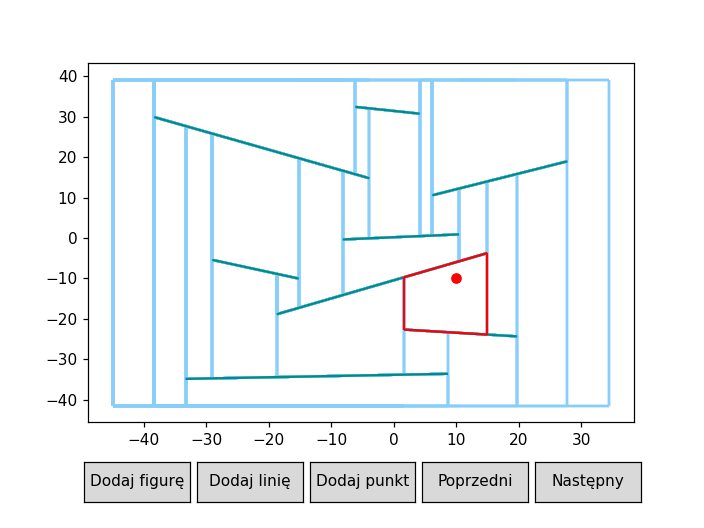

In [187]:
point = Point(10, -10)
findPoint(searchGraph, point, scenes[-1])

In [206]:
def trapezeLines(left,right,top,bottom):
    
    res = []
    res.append(((left,top.getY(left)),(right,top.getY(right))))
    res.append(((left,bottom.getY(left)),(right,bottom.getY(right))))
    res.append(((left,top.getY(left)),(left,bottom.getY(left))))
    res.append(((right,top.getY(right)),(right,bottom.getY(right))))  
    
    return res

def visualizeQuery(left,right,top,bottom,node,q,scenes,t1,background):
    
    background.lines.append(LinesCollection(trapezeLines(left,right,top,bottom), color="red"))
    scenes.append(Scene([PointsCollection([(t1.leftPoint.x,t1.topSegment.getY(t1.leftPoint.x)), (t1.rightPoint.x,t1.bottomSegment.getY(t1.leftPoint.x))], color = 'lightskyblue'),
                         PointsCollection([(q.x,q.y)],color = "red")],
                         background.lines[:]))    
    background.lines.pop()
    
    if node.type == "tnode":
        background.lines.append(LinesCollection(trapezeLines(node.trapezoid.leftPoint.x,node.trapezoid.rightPoint.x,node.trapezoid.topSegment,node.trapezoid.bottomSegment), color="red"))
        scenes.append(Scene([PointsCollection([(t1.leftPoint.x,t1.topSegment.getY(t1.leftPoint.x)), (t1.rightPoint.x,t1.bottomSegment.getY(t1.leftPoint.x))], color = 'lightskyblue'),
                             PointsCollection([(q.x,q.y)],color = "red")],
                             background.lines[:]))    
        background.lines.pop()
        
        return scenes
    elif node.type == "xnode":
        
        background.lines.append(LinesCollection(trapezeLines(left,right,top,bottom), color="red"))
        scenes.append(Scene([PointsCollection([(t1.leftPoint.x,t1.topSegment.getY(t1.leftPoint.x)), (t1.rightPoint.x,t1.bottomSegment.getY(t1.leftPoint.x))], color = 'lightskyblue'),
                         PointsCollection([(q.x,q.y)],color = "red"),
                         PointsCollection([(node.point.x,node.point.y)],color="black")],
                         background.lines[:]))    
        background.lines.pop()
        
        if(q.x < node.point.x):
            visualizeQuery(left,node.point.x,top,bottom,node.left,q,scenes,t1,background) 
        else: 
            visualizeQuery(node.point.x,right,top,bottom,node.right,q,scenes,t1,background) 
    else:
        
        background.lines.append(LinesCollection(trapezeLines(left,right,top,bottom), color="red"))
        scenes.append(Scene([PointsCollection([(t1.leftPoint.x,t1.topSegment.getY(t1.leftPoint.x)), (t1.rightPoint.x,t1.bottomSegment.getY(t1.leftPoint.x))], color = 'lightskyblue'),
                         PointsCollection([(q.x,q.y)],color = "red"),
                         PointsCollection([(node.segment.leftPoint.x,node.segment.getY(node.segment.leftPoint.x)),(node.segment.rightPoint.x,node.segment.getY(node.segment.rightPoint.x))],color="black")],
                         background.lines[:]))    
        background.lines.pop()
        
        if(q.y < node.segment.getY(q.x)):
            visualizeQuery(left,right,node.segment,bottom,node.below,q,scenes,t1,background) 
        else: 
            visualizeQuery(left,right,top,node.segment,node.above,q,scenes,t1,background) 
            
def visualizeQueryAlgorithm(point,backround,t1):
    scenes2 = []
    t1 = createOuterTrapezoid(lines)
    visualizeQuery(t1.leftPoint.x, t1.rightPoint.x, t1.topSegment,t1.bottomSegment,searchGraph.root,point,scenes2,t1,background)
    
    return scenes2

<IPython.core.display.Javascript object>


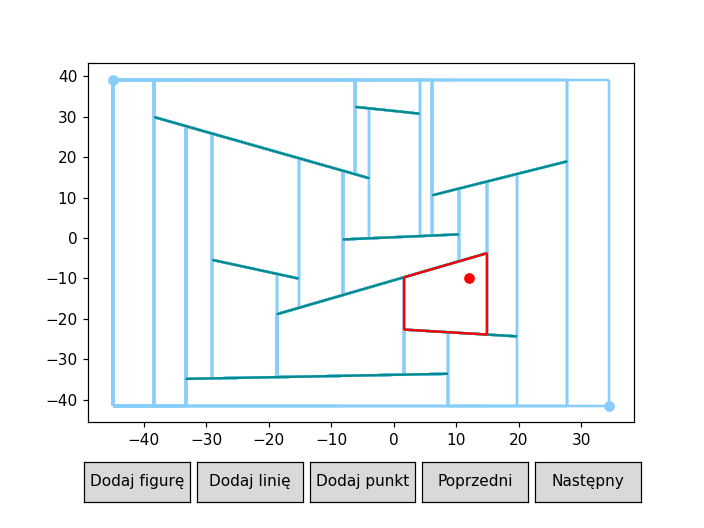

In [208]:
scenes2 = visualizeQueryAlgorithm(Point(12, -10),scenes[-1],createOuterTrapezoid(lines))
plot = Plot(scenes=scenes2)
plot.draw()